<a href="https://colab.research.google.com/github/alexaK88/Q_jpeg_pennylane/blob/main/QEK_training_KTA_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install pennylane pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 

### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QFT
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml, load_digits
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from pennylane import numpy as pnp
from skimage.transform import resize
from keras.datasets import mnist

### Dataset Preparation


First, we load the MNIST dataset from openML.
- X is the pixel data
- y is the labels
- converting everything to `uint8` here to ensure all values are integers in [0, 255]

In [3]:
# loading mnist from keras.datasets
from keras.datasets import mnist
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()
X = np.concatenate((X_train_full, X_test_full), axis=0)
y = np.concatenate((y_train_full, y_test_full), axis=0)

X = X.astype(np.uint8) # better to convert for binerization
y = y.astype(np.uint8)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Next, we focus on 2 classes, i.e. binary classification.
Here, I've been experimenting with different classes, and I stopped on 4 vs 9, cause they have more subtle difference in pixels, they are similar looking.

In [4]:
# focus on binary classification
mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]
X.shape

(14780, 28, 28)

- I take only the first `n_samples`.
- I convert X to a NumPy array, and shuffling the data randomly

In [5]:
n_samples = 200 # restricting to 6000 samples for now

X = X.values if hasattr(X, "values") else X # safer conversion

X = X[:n_samples]
y = y[:n_samples]

Now, I normalise pixel intensities.
- [0, 255] -> [0, 1]
- reshaping images back to 2D for resizing, i.e to 28x28 array with float values between 0 and 1.

In [6]:
X = X / 255.0
X = X.reshape(-1, 28, 28)

y = 2 * y - 1 # KTA requires labels in {-1, 1}

print(X.shape)
print("Pixel range:", X.min(), X.max())

(200, 28, 28)
Pixel range: 0.0 1.0


And now I reduce images to 8x8 + flattening to (, 64)
- resize -> flatten -> normalize

In [7]:
# convert each 28x28 binarised image to 8x8, then flatten to length 64
def to_8x8_vector(img_row):
    img_8x8 = resize(
        img_row,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True,
        order=1 # controlling interpolation
    )
    img_8x8 = img_8x8.flatten().astype(float)
    img_8x8 -= img_8x8.mean()
    norm = np.linalg.norm(img_8x8)
    if norm > 0:
        img_8x8 /= norm
    else:
        img_8x8[0] = 1.0
      # should be shape (64,)
    return img_8x8

# apply transformation to all images
X_8x8 = np.array([to_8x8_vector(x) for x in X], dtype=float)
X_8x8.shape

(200, 64)

In [8]:
# sanity check, make sure no NaNs exist and all vectors are normalised, i.e. norm is around 1
print("Any NaNs?", np.isnan(X_8x8).any())
print("Norm check:", np.min(np.linalg.norm(X_8x8, axis=1)), np.max(np.linalg.norm(X_8x8, axis=1)))

Any NaNs? False
Norm check: 0.9999999999999998 1.0000000000000002


I'm gonna do the splitting here, and carry both representations consistently.
- qek inputs: (64,) flattened and normalized vectors, for quantum kernel embedding
- qjpeg: 28x28 images

In [9]:
idx = np.arange(n_samples)

idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# QEK inputs (8x8 -> 64 -> normed)
X_train_qek = X_8x8[idx_train]
X_test_qek  = X_8x8[idx_test]

# QJPEG inputs (28x28 binary images)
X_train_img = X[idx_train]
X_test_img  = X[idx_test]

print("QEK train/test:", X_train_qek.shape, X_test_qek.shape)
print("IMG train/test:", X_train_img.shape, X_test_img.shape)
print("Labels train/test:", y_train.shape, y_test.shape)

QEK train/test: (160, 64) (40, 64)
IMG train/test: (160, 28, 28) (40, 28, 28)
Labels train/test: (160,) (40,)


Data preparation is done.

### Quantum Embedding & Kernel Training

Define number of qubits and device.

In [10]:
device = "lightning.qubit"
n_qubits = 6

In [11]:
dev = qml.device(device, wires=n_qubits, shots=None)

Defining the parametrised quantum circuit:

In [12]:
def quantum_circuit(x, theta):

    # Trainable block FIRST
    for l in range(theta.shape[0]):

        for q in range(n_qubits):
            qml.RY(theta[l, q, 0], wires=q)
            qml.RZ(theta[l, q, 1], wires=q)

        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q, q + 1])

        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q + 1, q])

    # THEN embed data
    qml.AmplitudeEmbedding(
        x,
        wires=range(n_qubits),
        normalize=False
    )

@qml.qnode(dev, interface="autograd")
def qek_kernel(x1, x2, theta):
    quantum_circuit(x1, theta)
    qml.adjoint(quantum_circuit)(x2, theta)
    return qml.expval(qml.Projector([0]*n_qubits, wires=range(n_qubits)))

def compute_kernel_matrix(X1, X2, theta):
    """
    Compute the quantum kernel matrix K_ij = K_theta(X1[i], X2[j])

    Args:
        X1: array of shape (N1, d)
        X2: array of shape (N2, d)
        theta: trained QEK parameters

    Returns:
        K: (N1, N2) kernel matrix
    """
    N1, N2 = len(X1), len(X2)
    K = np.zeros((N1, N2))

    for i in range(N1):
        for j in range(N2):
            K[i, j] = qek_kernel(X1[i], X2[j], theta)

    return K

def kta_loss_full(theta, X, y):
    def _kernel(x1, x2):
        return qek_kernel(x1, x2, theta)
    return -qml.kernels.target_alignment(X_train_qek, y_train, kernel=_kernel)


def kta_loss_minibatch(theta, X, y, batch_size=8):
    idx = np.random.choice(len(X), batch_size, replace=False)
    Xb = X[idx]
    yb = y[idx]

    # Define a kernel function that takes x1, x2 and uses the current theta
    def _kernel_fn(x1, x2):
        return qek_kernel(x1, x2, theta)

    # PennyLane's KTA
    return -qml.kernels.target_alignment(Xb, yb, kernel=_kernel_fn)

def model(X, theta, w, b):
    phi = qek_kernel(X, X, theta)
    return np.dot(w, phi) + b

def hinge_loss(theta, w, b, X, y, C=1.0):
    preds = []
    for i in range(len(X)):
        preds.append(model(X[i], theta, w, b))

    preds = qml.math.stack(preds)

    margins = y * preds
    hinge = qml.math.mean(qml.math.maximum(0.0, 1.0 - margins)**2)

    reg = 0.5 * qml.math.dot(w, w)

    return reg + C * hinge


In [13]:
n_features = n_qubits
w = 0.01 * pnp.random.randn(n_features, requires_grad=True)
b = pnp.array(0.0, requires_grad=True)

In [14]:
n_layers = 4
n_steps = 600
batch_size = 16
stepsize = 5e-3
# momentum = 0.9

subset_train = 50
subset_test  = 50

X_train_subset = X_train_qek[:subset_train]
y_train_subset = y_train[:subset_train]

theta = 0.3 * pnp.random.randn(n_layers, n_qubits, 2)
opt = qml.AdamOptimizer(stepsize=stepsize)

ema = None

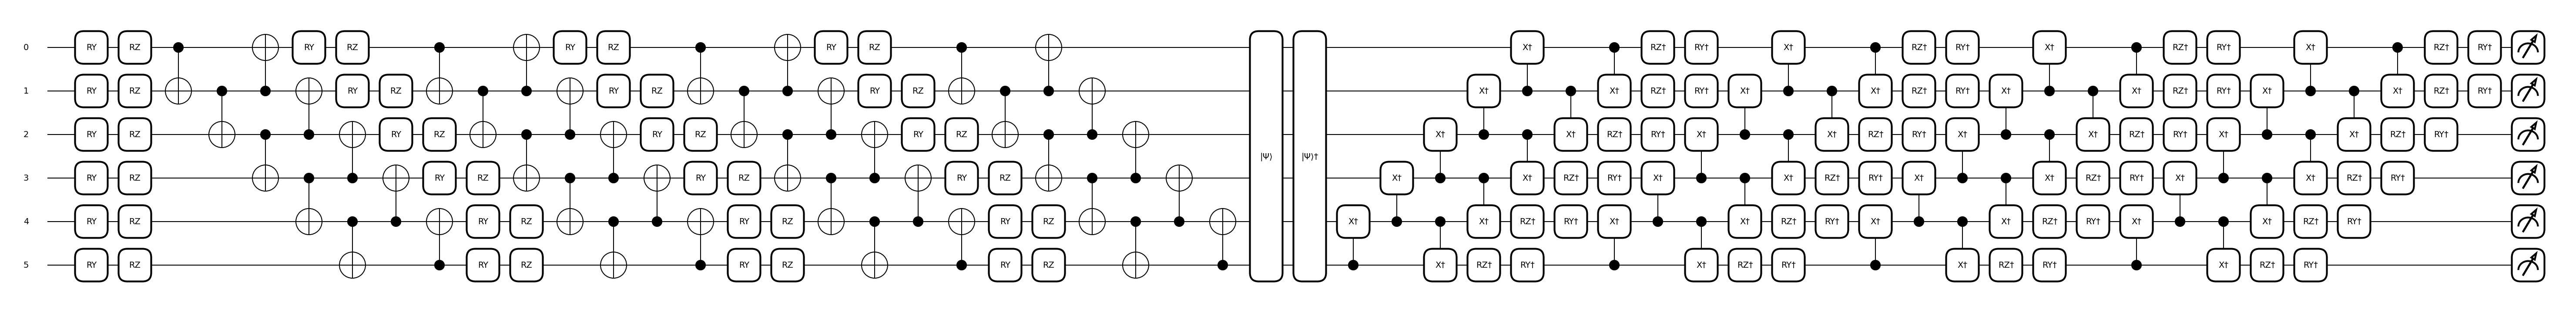

In [15]:
fig, ax = qml.draw_mpl(qek_kernel)(X_train_subset[0], X_train_subset[0], theta)
fig.show()

In [16]:
K = compute_kernel_matrix(X_train_subset, X_train_subset, theta)

# this is a pure sanity check of the kernel on a subset of samples
print("Kernel min :", K.min())
print("Kernel max :", K.max())
print("Kernel mean:", K.mean())

# Symmetry check (should be ~0)
print("Symmetry error:", np.max(np.abs(K - K.T)))

Kernel min : 0.00017749249073723455
Kernel max : 1.0000000000000044
Kernel mean: 0.21754615453533543
Symmetry error: 1.887379141862766e-15


In [17]:
theta_pert = theta + 0.1 * np.random.randn(*theta.shape)
print("Loss perturbed:", kta_loss_full(theta_pert, X_train_qek, y_train))

Loss perturbed: -0.484429879172836


In [18]:
for step in range(n_steps):
    theta, loss = opt.step_and_cost(
        lambda t: kta_loss_minibatch(
            t, X_train_qek, y_train, batch_size
        ),
        theta
    )
    loss = qml.math.clip(loss, -1.0, 1.0) # clipping stabilizes gradients

    ema = loss if ema is None else 0.9 * ema + 0.1 * loss

    if step % 20 == 0:
        # loss_full = kta_loss_full(theta, X_train_qek, y_train)
        print(f"Step {step:02d} | loss={loss:.4f} | ema={ema:.4f}")


Step 00 | loss=-0.3443 | ema=-0.3443
Step 20 | loss=-0.6505 | ema=-0.5308
Step 40 | loss=-0.6672 | ema=-0.5352
Step 60 | loss=-0.7629 | ema=-0.6206
Step 80 | loss=-0.5555 | ema=-0.5800
Step 100 | loss=-0.7666 | ema=-0.6659
Step 120 | loss=-0.6981 | ema=-0.6466
Step 140 | loss=-0.5047 | ema=-0.6419
Step 160 | loss=-0.5086 | ema=-0.6721
Step 180 | loss=-0.3566 | ema=-0.6492
Step 200 | loss=-0.7305 | ema=-0.6399
Step 220 | loss=-0.5358 | ema=-0.6417
Step 240 | loss=-0.4362 | ema=-0.6029
Step 260 | loss=-0.5539 | ema=-0.6096
Step 280 | loss=-0.7424 | ema=-0.6159
Step 300 | loss=-0.4519 | ema=-0.6364
Step 320 | loss=-0.5943 | ema=-0.6336
Step 340 | loss=-0.5486 | ema=-0.6725
Step 360 | loss=-0.6924 | ema=-0.6307
Step 380 | loss=-0.6672 | ema=-0.6737
Step 400 | loss=-0.5365 | ema=-0.6548
Step 420 | loss=-0.5284 | ema=-0.6763
Step 440 | loss=-0.3285 | ema=-0.6005
Step 460 | loss=-0.6339 | ema=-0.6593
Step 480 | loss=-0.8092 | ema=-0.6450
Step 500 | loss=-0.6345 | ema=-0.6405
Step 520 | loss=-

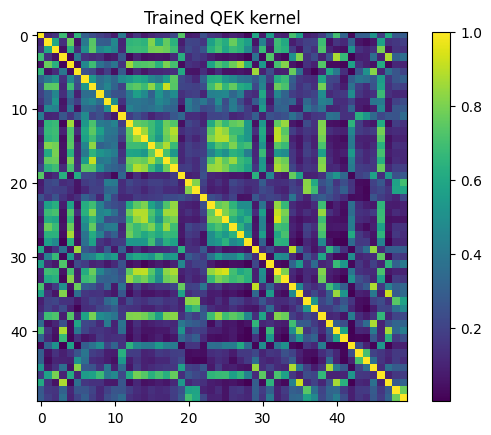

In [19]:
K = compute_kernel_matrix(X_train_subset, X_train_subset, theta)

# visualise the kernel
plt.imshow(K, cmap="viridis")
plt.colorbar()
plt.title("Trained QEK kernel")
plt.show()

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_test_subset = X_test_qek[:subset_test]
y_test_subset = y_test[:subset_test]

# Compute kernel matrices using your trained theta
def compute_kernel_matrix(X1, X2, theta):
    N1, N2 = len(X1), len(X2)
    K = np.zeros((N1, N2))
    for i in range(N1):
        for j in range(N2):
            K[i, j] = qek_kernel(X1[i], X2[j], theta)
    return K

# Training kernel
K_train = compute_kernel_matrix(X_train_subset, X_train_subset, theta)
# Testing kernel
K_test  = compute_kernel_matrix(X_test_subset, X_train_subset, theta)

# SVM with precomputed kernel
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train_subset)

# Predict & evaluate
y_pred = svm.predict(K_test)
acc = accuracy_score(y_test_subset, y_pred)

print(f"SVM accuracy with trained QEK kernel: {acc:.4f}")


SVM accuracy with trained QEK kernel: 1.0000
